<a href="https://colab.research.google.com/github/sheshrajkandel/news-sentiment-stock-price-prediction/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Import the required packages**

In [51]:
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import pandas as pd
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error

###**Input dataset**

In [56]:
stock_news_score_data = "/content/drive/MyDrive/Dissertation/nabil_stock_score_data.csv"
stock_data = "/content/drive/MyDrive/Dissertation/NABIL_raw_stock_data.csv"

#for filename
m_name=''
m_set=''

#1. Dataset with sentiment score
#2. Dataset without sentiment score (Only stock dataset)
dataset_choice = int(input("Choose the dataset: "))

if(dataset_choice == 1):
  df = read_csv(stock_news_score_data, header=0, index_col=0)
  dataset = df[['Close','Open','High','Low','Volume','SA_Score']]    
  n_features = 6
  m_set = 'All' #for filename
elif(dataset_choice == 2):
  df = read_csv(stock_data, header=0, index_col=0)
  dataset = df[['Close','Open','High','Low','Volume']]
  n_features = 5
  m_set = 'Only'
else:
  print('Wrong Input! Please choose dataset.')

dataset.head()

Choose the dataset: 1


,Close,Open,High,Low,Volume,SA_Score
Date,,,,,,
2022-05-31,875.0,890.0,890.0,865.0,45502,0.0000
2022-05-30,890.0,900.0,901.0,881.0,44382,0.3680
2022-05-27,898.0,900.0,900.0,896.0,39790,0.4019
2022-05-26,898.6,918.0,918.0,897.0,39717,0.0000
2022-05-25,900.0,915.0,915.0,898.0,38263,0.0000


In [57]:
dataset=dataset.reset_index()
dataset.head()

,Date,Close,Open,High,Low,Volume,SA_Score
0,2022-05-31,875.0,890.0,890.0,865.0,45502,0.0000
1,2022-05-30,890.0,900.0,901.0,881.0,44382,0.3680
2,2022-05-27,898.0,900.0,900.0,896.0,39790,0.4019
3,2022-05-26,898.6,918.0,918.0,897.0,39717,0.0000
4,2022-05-25,900.0,915.0,915.0,898.0,38263,0.0000


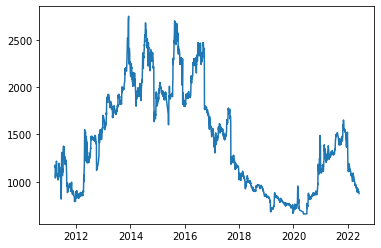

In [58]:
#Set the date as index of dataset
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
dataset.set_index('Date',drop = True,inplace=True)

#Plot the closing price for trend analysis
plt.plot(dataset['Close'])


In [59]:
dataset.head()

,Close,Open,High,Low,Volume,SA_Score
Date,,,,,,
2022-05-31,875.0,890.0,890.0,865.0,45502,0.0000
2022-05-30,890.0,900.0,901.0,881.0,44382,0.3680
2022-05-27,898.0,900.0,900.0,896.0,39790,0.4019
2022-05-26,898.6,918.0,918.0,897.0,39717,0.0000
2022-05-25,900.0,915.0,915.0,898.0,38263,0.0000


In [60]:
dataset=dataset.sort_index()
dataset.head()

,Close,Open,High,Low,Volume,SA_Score
Date,,,,,,
2011-03-20,1170.0,1200.0,1190.0,1160.0,853,0.0
2011-03-24,1153.0,1162.0,1178.0,1150.0,356,0.0
2011-03-25,1174.0,1153.0,1174.0,1145.0,702,0.0
2011-03-27,1147.0,1174.0,1160.0,1120.0,1426,0.0
2011-03-28,1132.0,1147.0,1150.0,1110.0,352,0.0


###**Convert series to supervised learning**

In [61]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	#Forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	#Put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	#Drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [62]:
#Prepare for the time-series generation

data = series_to_supervised(dataset, 12,1)
values = dataset.values
values = values.astype('float32')

#Normalize the data using min-max normalizations
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#Specify the number of lag hours 10,12,14,16,18,20
n_lag = 12

#Frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, 1)

###**Split into train, validation and test sets**

In [63]:
values = reframed.values
n_train = int(365 * 4)
n_val=int(n_train*0.8)
train = values[:n_val, :]
val=values[n_val:n_train,:]
test = values[n_train:, :]

In [64]:
#store the test data set index for comparing it with result
x_test_panda=dataset.iloc[n_train:,:]

In [65]:
#Split into input and outputs
n_obs = n_lag * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
val_X, val_y=val[:,:n_obs],val[:,-n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(1168, 72) 1168 (1168,)


In [66]:
#Reshape input to be 3D [samples, timesteps, features]
train_X = np.reshape(train_X, (train_X.shape[0], n_lag, n_features))
val_X = np.reshape(val_X, (val_X.shape[0], n_lag, n_features))
test_X = np.reshape(test_X, (test_X.shape[0], n_lag, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1168, 12, 6) (1168,) (1056, 12, 6) (1056,)


In [68]:
def plot_history(history):
  #Plot history
  pyplot.plot(history.history['loss'], label='Train')
  pyplot.plot(history.history['val_loss'], label='Test')
  pyplot.legend()
  pyplot.show()

In [69]:
model = Sequential()
model.add(LSTM(120,input_shape=(train_X.shape[1], train_X.shape[2])))
m_name = 'LSTM'
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mse','mae'])

Epoch 1/100
39/39 - 3s - loss: 0.0047 - mse: 0.0047 - mae: 0.0546 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0261 - 3s/epoch - 73ms/step
Epoch 2/100
39/39 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0302 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0249 - 472ms/epoch - 12ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0285 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0239 - 494ms/epoch - 13ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0288 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0243 - 467ms/epoch - 12ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0297 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0268 - 471ms/epoch - 12ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0308 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0291 - 475ms/epoch - 12ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0292 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0234 

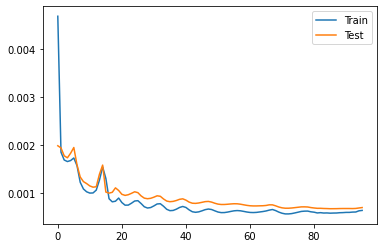

In [70]:
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=2, shuffle=False)

plot_history(history)

In [71]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))

In [72]:
#Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [73]:
#Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [74]:
def da(y_true,y_pred):
  sum=0
  for i in range(y_true.size-1):
    dt=(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_true[i])
    if(dt>=0):
      sum=sum+1
  return sum/(y_true.size-1)

In [75]:
def evaluateModel(inv_y,inv_yhat):
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)
  print('R2_Score: %.3f' % r2_score(inv_y,inv_yhat))
  print("MAE:", mean_absolute_error(inv_y,inv_yhat))
  print("Directionnal Accuracy:", da(inv_y,inv_yhat))

In [76]:
evaluateModel(inv_yhat,inv_y)

Test RMSE: 108.016
R2_Score: 0.837
MAE: 90.508354
Directionnal Accuracy: 0.5895734597156398


In [77]:
def trend_error(y_true,y_pred,n):
  s=type_one=type_two=0
  for i in range(y_true.size-1):
    actual_diff=y_true[i+1]-y_true[i]
    pred_diff=y_pred[i+1]-y_true[i]
    if(actual_diff<0 and pred_diff>0):
      type_one=type_one+1
    elif(actual_diff>0 and pred_diff<0):
      type_two=type_two+1
    else:
      s=s+1
  return (s/n,type_one/n,type_two/n)

In [78]:
trend_error(inv_y,inv_yhat, inv_y.size)

(0.4914772727272727, 0.5075757575757576, 0.0)

In [79]:
df = pd.DataFrame({'Actual':inv_y,'Predicted':inv_yhat,'Error': inv_y-inv_yhat,})

print(df.shape)
print(x_test_panda.shape)

(1056, 3)
(1068, 6)


In [80]:
y=x_test_panda.iloc[12:,]
true=y['Close']

true_x=np.array(true)
pred_x=np.array(df['Actual'])

In [81]:
count=0
for i in range(true_x.size):
  if(true_x[i]==int(pred_x[i])):
    count=count+1
print(count)

1014


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1cb142c50>,
      dtype=object)

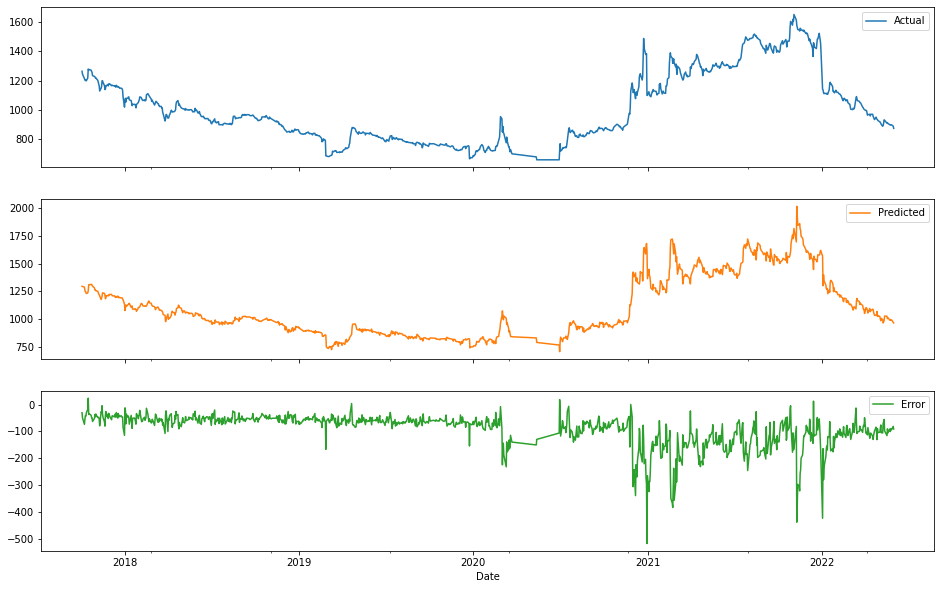

In [82]:
output_data=df.set_index(y.index)

output_data.plot(subplots=True, figsize=(16, 10))

In [85]:
#Save the output of each model to perform the DM-Test
file_path = "/content/drive/MyDrive/Dissertation/"
file_name = file_path + m_name + '_' + m_set +'_Result.csv'
output_data.to_csv(file_name,index=True)
